In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score
from sklearn.decomposition import KernelPCA, PCA
import warnings
warnings.filterwarnings("ignore")

In [8]:
X_train = pd.read_csv("preprocessing_data.csv")

## Reduce dimensionality, using both kPCA and PCA

In [9]:
# Find best number of components and gamma for kernel PCA - RBF

#! n_components
kpca = KernelPCA(random_state=123, kernel='rbf', gamma=0.01, max_iter=100)
kpca.fit(X_train)

eigenvalues = kpca.eigenvalues_
cum_var = np.cumsum(eigenvalues) / np.sum(eigenvalues)
n_components_95 = np.argmax(cum_var >= 0.95)


#! gamma
gamma_range = np.logspace(-5, 0, 6)

best_s_score = 0
best_params = {}

for gamma in gamma_range:
    kpca = KernelPCA(n_components=n_components_95, random_state=123, kernel='rbf', gamma=gamma, max_iter=100)
        
    X_train_kpca = kpca.fit_transform(X_train)
        
    kmeans = KMeans(n_clusters=20, random_state=123)
    kmeans.fit(X_train_kpca)
        
    s_score = silhouette_score(X_train_kpca, kmeans.labels_, random_state=123)
        
    if s_score > best_s_score:
        best_s_score = s_score
        best_params = {'n_components': n_components_95, 'gamma': gamma}
                    
print(f'Best parameters: {best_params}')

Best parameters: {'n_components': 564, 'gamma': 1e-05}


In [10]:
kpca = KernelPCA(n_components=best_params['n_components'], random_state=123, kernel='rbf', gamma=best_params['gamma'], max_iter=100)
X_train_kpca = kpca.fit_transform(X_train)

X_train_kpca.shape

(600, 564)

In [11]:
n_cluster_range = range(3, 26)

silhouette_scores = []

for n_clusters in n_cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=123, n_init=50, init='k-means++')
    kmeans.fit(X_train_kpca)
    
    silhouette_avg = silhouette_score(X_train_kpca, kmeans.labels_, random_state=123)
    silhouette_scores.append(silhouette_avg)
    
best_n_clusters = n_cluster_range[np.argmax(silhouette_scores)]

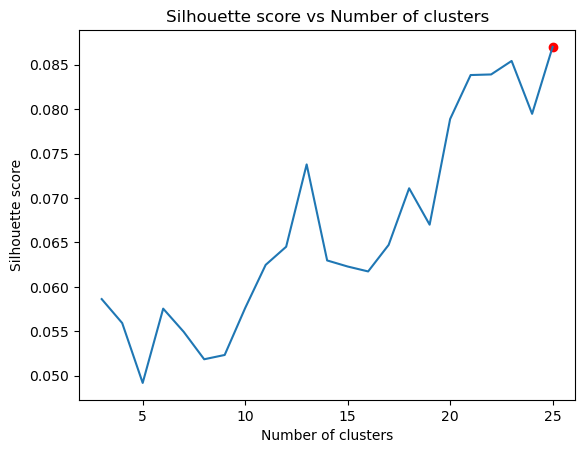

Best number of clusters: 25


In [12]:
plt.plot(n_cluster_range, silhouette_scores)
plt.scatter(best_n_clusters, max(silhouette_scores), color='red', label='Best number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs Number of clusters')
plt.show()

print(f'Best number of clusters: {best_n_clusters}')

In [13]:
kmeans = KMeans(n_clusters=best_n_clusters, random_state=123, max_iter=1000, n_init=50, init='k-means++')
kmeans.fit(X_train_kpca)
kmeans_labels = kmeans.predict(X_train_kpca)

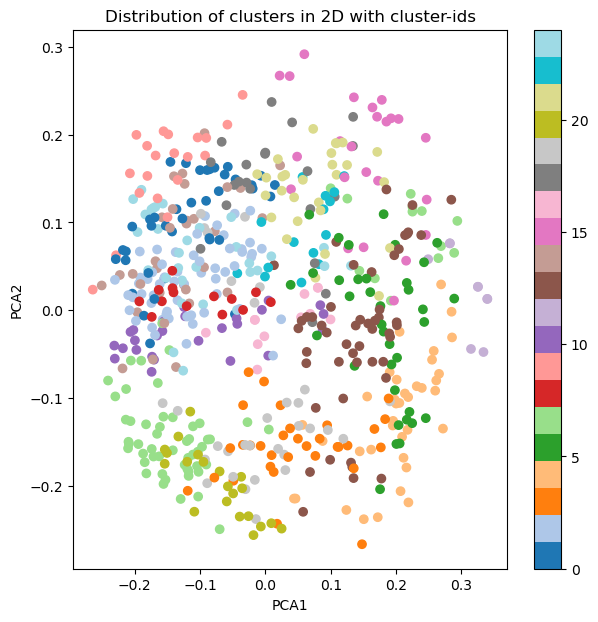

In [14]:
# Plot the distribution of clusters in 2D with their labels
plt.figure(figsize=(7, 7))
plt.scatter(X_train_kpca[:, 0], X_train_kpca[:, 1], c=kmeans_labels, cmap='tab20')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Distribution of clusters in 2D with cluster-ids')
plt.colorbar()
plt.show()

In [15]:
pca = PCA(n_components=0.95, random_state=123)
X_train_pca = pca.fit_transform(X_train)

In [16]:
X_train_pca.shape

(600, 314)

In [17]:
n_cluster_range = range(3, 26)

silhouette_scores = []

for n_clusters in n_cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=123, n_init=50, init='k-means++')
    kmeans.fit(X_train_pca)
    
    silhouette_avg = silhouette_score(X_train_pca, kmeans.labels_, random_state=123)
    silhouette_scores.append(silhouette_avg)
    
best_n_clusters = n_cluster_range[np.argmax(silhouette_scores)]

In [18]:
best_n_clusters

23

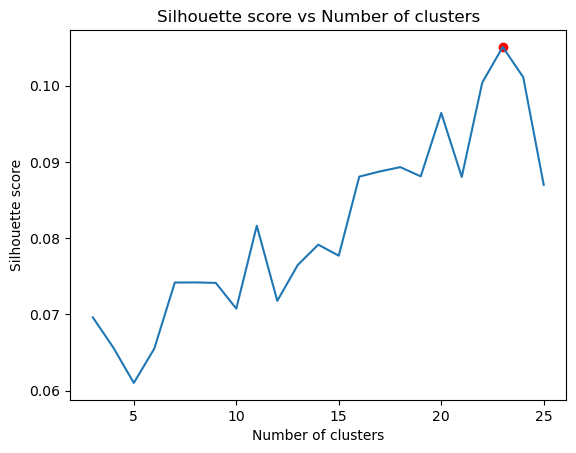

In [19]:
plt.plot(n_cluster_range, silhouette_scores)
plt.scatter(best_n_clusters, max(silhouette_scores), color='red', label='Best number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs Number of clusters')
plt.show()

In [20]:
kmeans_pca = KMeans(n_clusters=best_n_clusters, random_state=123, max_iter=1000, n_init=50, init='k-means++')
kmeans_pca.fit(X_train_pca)
kmeans_labels_pca = kmeans_pca.predict(X_train_pca)

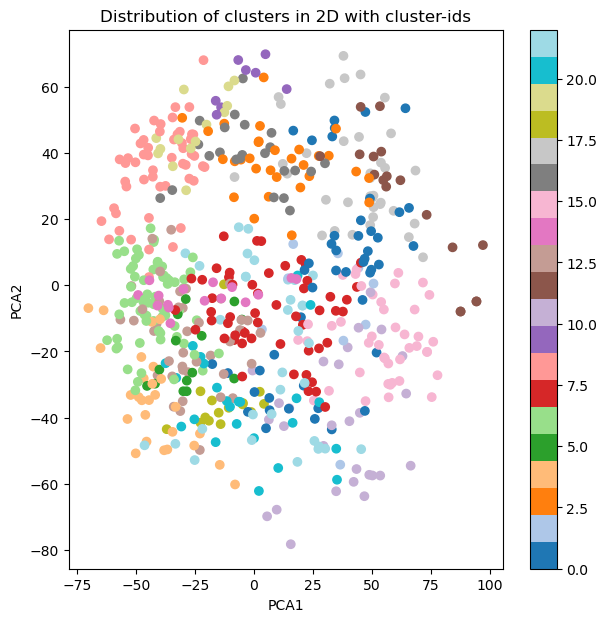

In [21]:
# Plot the distribution of clusters in 2D with their labels
plt.figure(figsize=(7, 7))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=kmeans_labels_pca, cmap='tab20')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Distribution of clusters in 2D with cluster-ids')
plt.colorbar()
plt.show()

In [26]:
umist_data = pd.read_csv("umist_cropped.csv")

In [31]:
# Add the cluster labels to the umist data
umist_data['cluster_id'] = kmeans_labels_pca

# Save the data
umist_data.to_csv('umist_cropped_clustered.csv', index=False)